In [1]:
# import system libs
import os
import time
import random
import pathlib
import itertools
from glob import glob
from tqdm import tqdm_notebook, tnrange

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

# import Deep learning Libraries
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Input, Activation,  Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, BatchNormalization, SeparableConv2D

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [3]:
def create_gens(df, aug_dict):
    img_size = (128, 128)
    batch_size = 40


    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    # Create general generator
    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix= 'mask', seed=1)

    gen = zip(image_gen, mask_gen)

    for (img, msk) in gen:
        img = img / 255
        msk = msk / 255
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)

In [4]:
def low_rank_conv_block(inputs, filters, kernel_size=3):
    """
    Low Rank Factorization of a 3x3 convolution.
    This block approximates a 3x3 convolution by applying a 3x1 conv followed by a 1x3 conv.
    An activation is applied between the two and batch normalization after the second convolution.
    """
    x = Conv2D(filters, (kernel_size, 1), kernel_initializer='he_normal', padding='same')(inputs)
    x = Activation('relu')(x)
    x = Conv2D(filters, (1, kernel_size), kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    return x

def unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Contracting path using low rank factorized conv blocks
    c1 = low_rank_conv_block(inputs, 16)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = low_rank_conv_block(p1, 32)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = low_rank_conv_block(p2, 48)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = low_rank_conv_block(p3, 64)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = low_rank_conv_block(p4, 64)

    # Expanding path using Conv2DTranspose for upsampling
    u6 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4], axis=3)
    c6 = low_rank_conv_block(u6, 64)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3], axis=3)
    c7 = low_rank_conv_block(u7, 48)

    u8 = Conv2DTranspose(48, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2], axis=3)
    c8 = low_rank_conv_block(u8, 32)

    u9 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = low_rank_conv_block(u9, 16)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

    return Model(inputs, outputs)

In [5]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [6]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]
        # read image and convert it to RGB scale
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # read mask
        mask = cv2.imread(mask_path)
        # sho image and mask
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_coef']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_coef']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_iou = np.argmax(iou_coef)
    iou_highest = val_iou[index_iou]
    index_dice = np.argmax(dice_coef)
    dice_highest = val_dice[index_dice]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training IoU
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label= 'Training Dice')
    plt.plot(Epochs, val_dice, 'g', label= 'Validation Dice')
    plt.scatter(index_dice + 1 , dice_highest, s= 150, c= 'blue', label= dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

Mounted at /content/drive


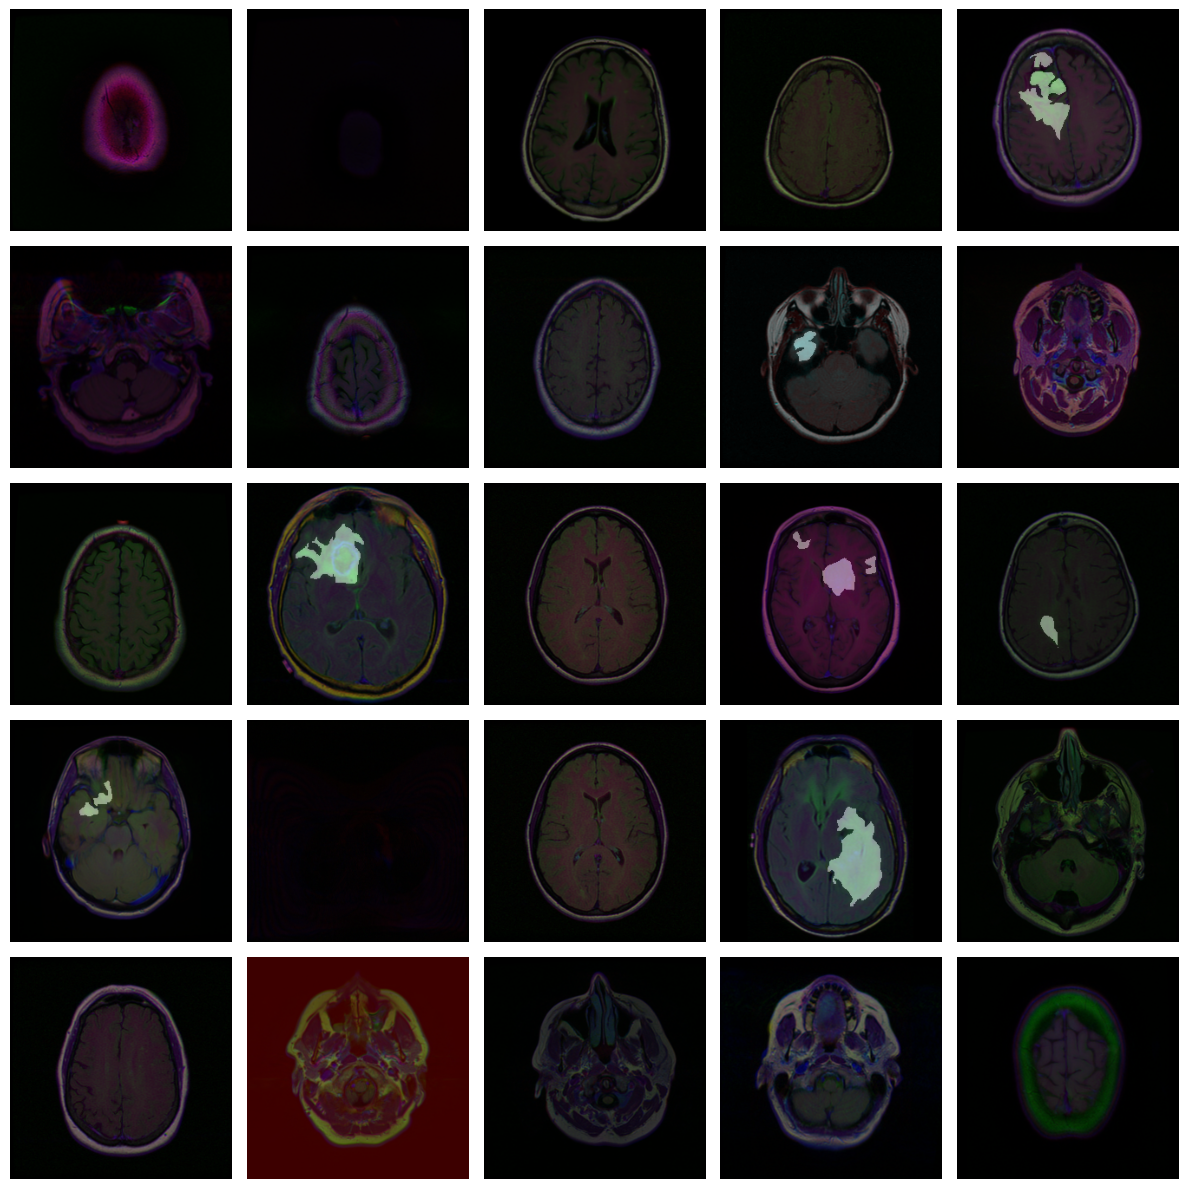

In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Update the data directory to point to your dataset on Google Drive
data_dir = '/content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m'

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)


tr_aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')


train_gen = create_gens(train_df, aug_dict=tr_aug_dict)
valid_gen = create_gens(valid_df, aug_dict={})
test_gen = create_gens(test_df, aug_dict={})

show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

In [9]:
model = unet()
model.compile(Adamax(learning_rate= 0.001), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │            784 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          1,568 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          3,104 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 32)     │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 48)     │          4,656 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 32, 32, 48)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 48)     │          6,960 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 48)     │            192 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 185,457 (724.44 KB)

 Trainable params: 184,689 (721.44 KB)

 Non-trainable params: 768 (3.00 KB)

In [10]:
import math
callbacks = [ModelCheckpoint('/content/drive/MyDrive/unet_final_low_rank.keras', verbose=1, save_best_only=True)]
epochs = 120
batch_size = 40

history = model.fit(train_gen,steps_per_epoch=math.ceil(len(train_df) / batch_size),epochs=epochs,verbose=1,callbacks=callbacks,validation_data=valid_gen,validation_steps=math.ceil(len(valid_df) / batch_size))


Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/120
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.6206 - dice_coef: 0.0390 - iou_coef: 0.0201 - loss: -0.0390 Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02484, saving model to /content/drive/MyDrive/unet_final_low_rank.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 2261s 29s/step - accuracy: 0.6218 - dice_coef: 0.0391 - iou_coef: 0.0202 - loss: -0.0391 - val_accuracy: 0.0594 - val_dice_coef: 0.0251 - val_iou_coef: 0.0128 - val_loss: -0.0248
Epoch 2/120
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.9128 - dice_coef: 0.0746 - iou_coef: 0.0392 - loss: -0.0746
Epoch 2: val_loss improved from -0.02484 to -0.04901, saving model to /content/drive/MyDrive/unet_final_low_rank.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 531ms/step - accuracy: 0.9130 - dice_coef: 0.0747 - iou_coef: 0.0393 - loss: -0.0747 - val_accuracy: 0.8317 - val_dice_coef: 0.

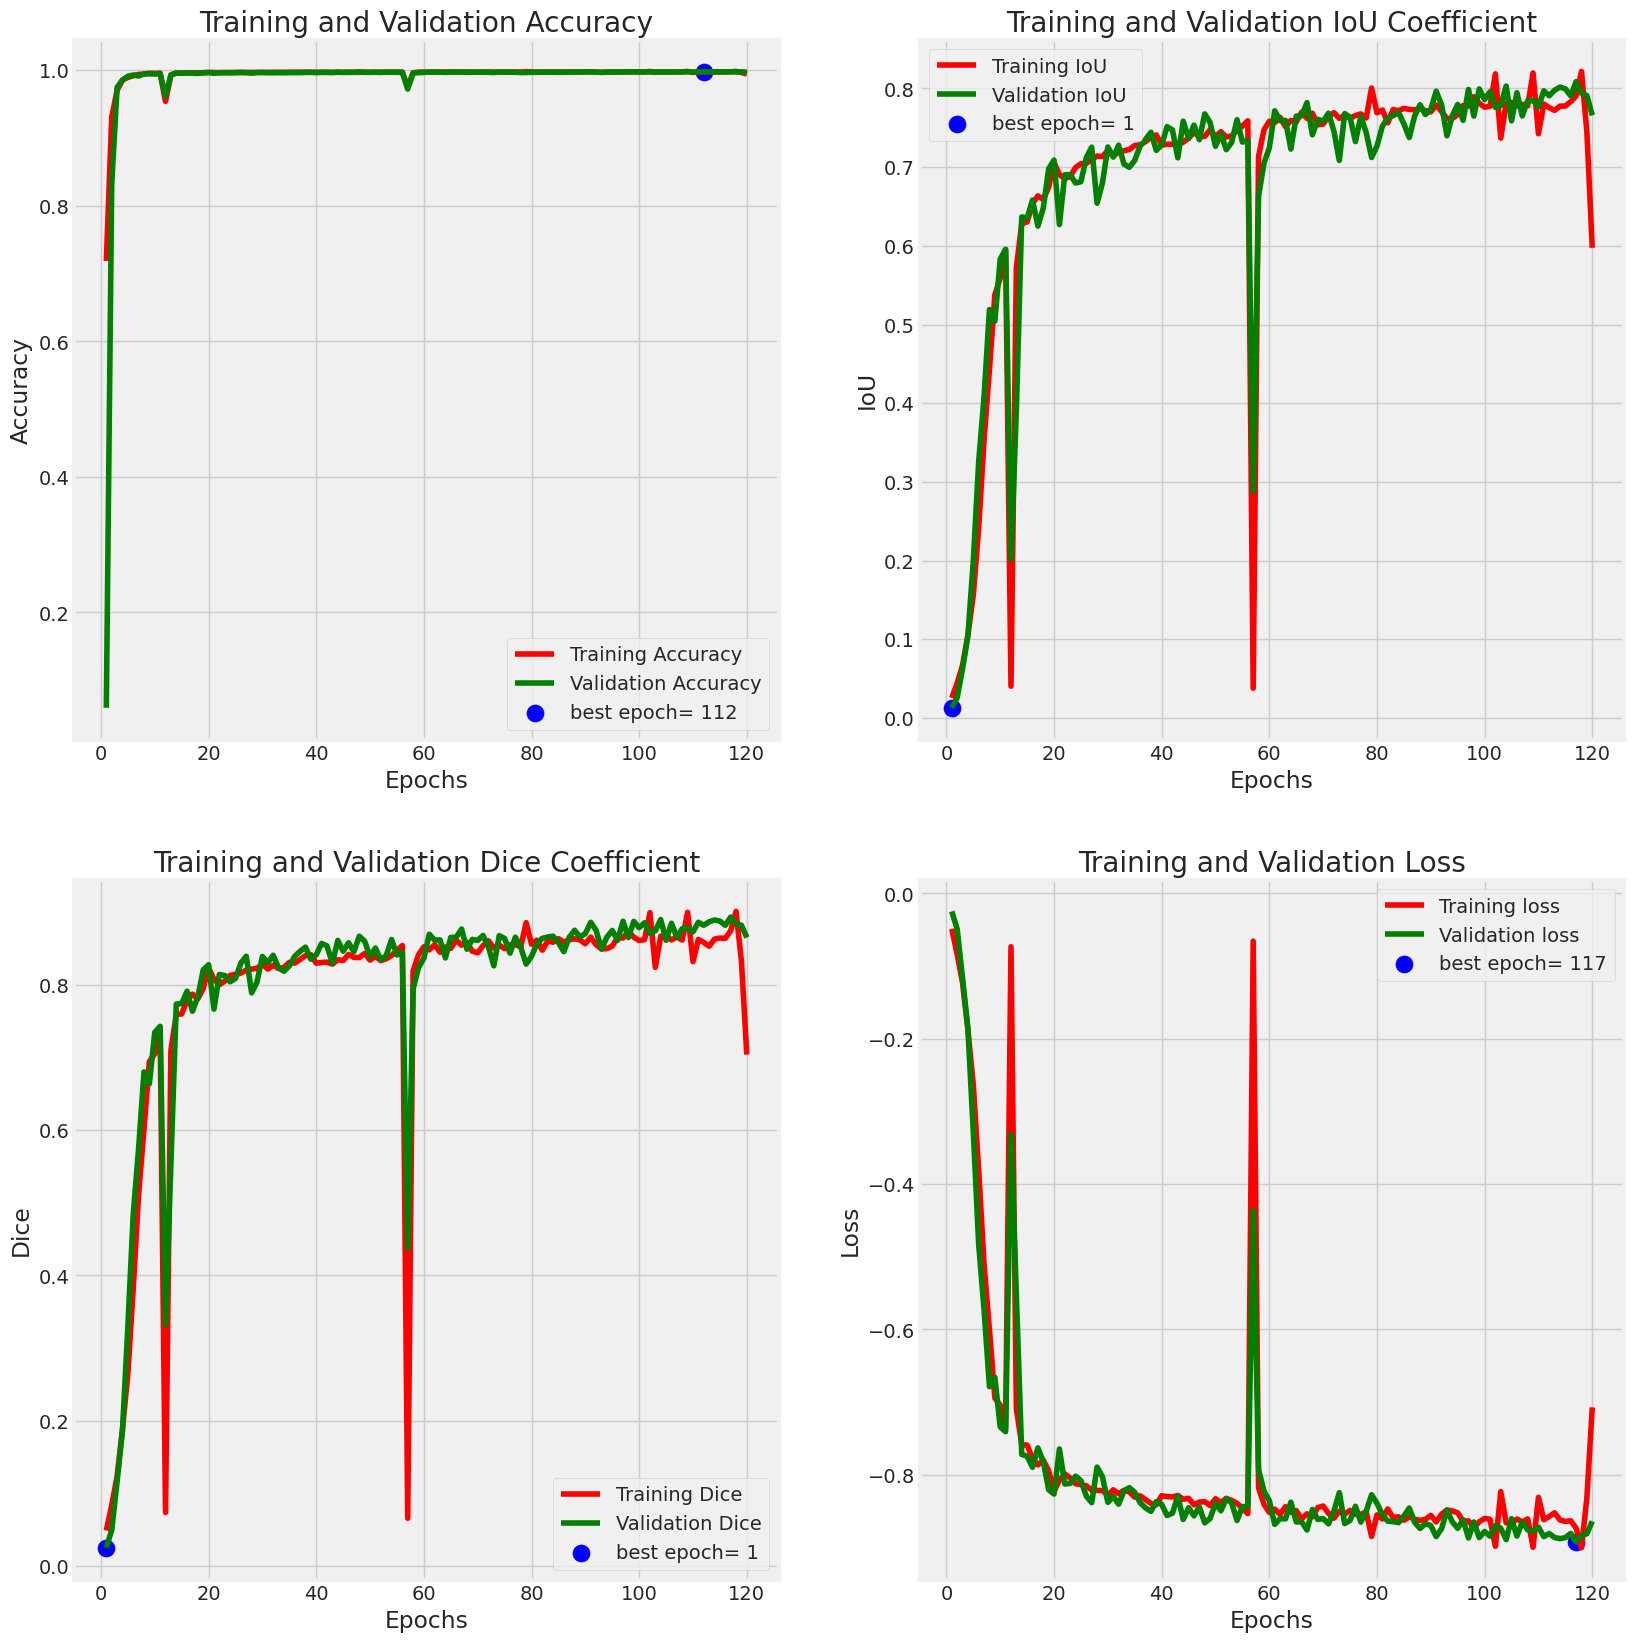

In [11]:
plot_training(history)

In [12]:
model.save('/content/drive/MyDrive/unet_final_low_rank.h5')


In [13]:
model.save('/content/drive/MyDrive/unet_final_low_rank.hdf5')


In [14]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])

131/131 ━━━━━━━━━━━━━━━━━━━━ 62s 477ms/step - accuracy: 0.9978 - dice_coef: 0.8908 - iou_coef: 0.8059 - loss: -0.8907
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 277ms/step - accuracy: 0.9971 - dice_coef: 0.8613 - iou_coef: 0.7616 - loss: -0.8610
Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9973 - dice_coef: 0.8535 - iou_coef: 0.7505 - loss: -0.8533
Train Loss:  -0.8942046761512756
Train Accuracy:  0.9979580640792847
Train IoU:  0.8114789724349976
Train Dice:  0.8943598866462708
--------------------
Valid Loss:  -0.8592451810836792
Valid Accuracy:  0.997107744216919
Valid IoU:  0.7591414451599121
Valid Dice:  0.8594059944152832
--------------------
Test Loss:  -0.8510347008705139
Test Accuracy:  0.9972019195556641
Test IoU:  0.7477269172668457
Test Dice:  0.8514240384101868


In [15]:
for _ in range(20):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (128, 128))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))

    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')

    plt.show()

Output hidden; open in https://colab.research.google.com to view.